In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pmdarima as pm
import joblib
import warnings
warnings.filterwarnings("ignore")

# Налаштування візуалізацій
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (18, 8)

# Завантажуємо дані
data_path = '../data/dataset_for_modeling.csv'
df = pd.read_csv(data_path, index_col='DateTime', parse_dates=True)
df_daily = df['Global_active_power'].resample('D').sum()

# Розділяємо дані
train_data = df_daily.loc[:'2009-12-31']
test_data = df_daily.loc['2010-01-01':]

print("Дані для моделі ARIMA готові.")

Дані для моделі ARIMA готові.


In [6]:
# auto_arima для НЕ-сезонної моделі
arima_model = pm.auto_arima(train_data,
                            start_p=1, start_q=1,
                            test='adf',
                            max_p=5, max_q=5,
                            m=1,             # m=1 для не-сезонної моделі
                            d=None,
                            seasonal=False,  # <--- КЛЮЧОВА ЗМІНА
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

print("\nЗведена інформація про найкращу модель ARIMA:")
print(arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=15681.725, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=16544.354, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=16082.313, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=16275.628, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=15682.329, Time=0.24 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=15682.139, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=16174.420, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=15964.989, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=15683.638, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=15703.864, Time=0.04 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 0.824 seconds

Зведена інформація про найкращу модель ARIMA:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1104
Model

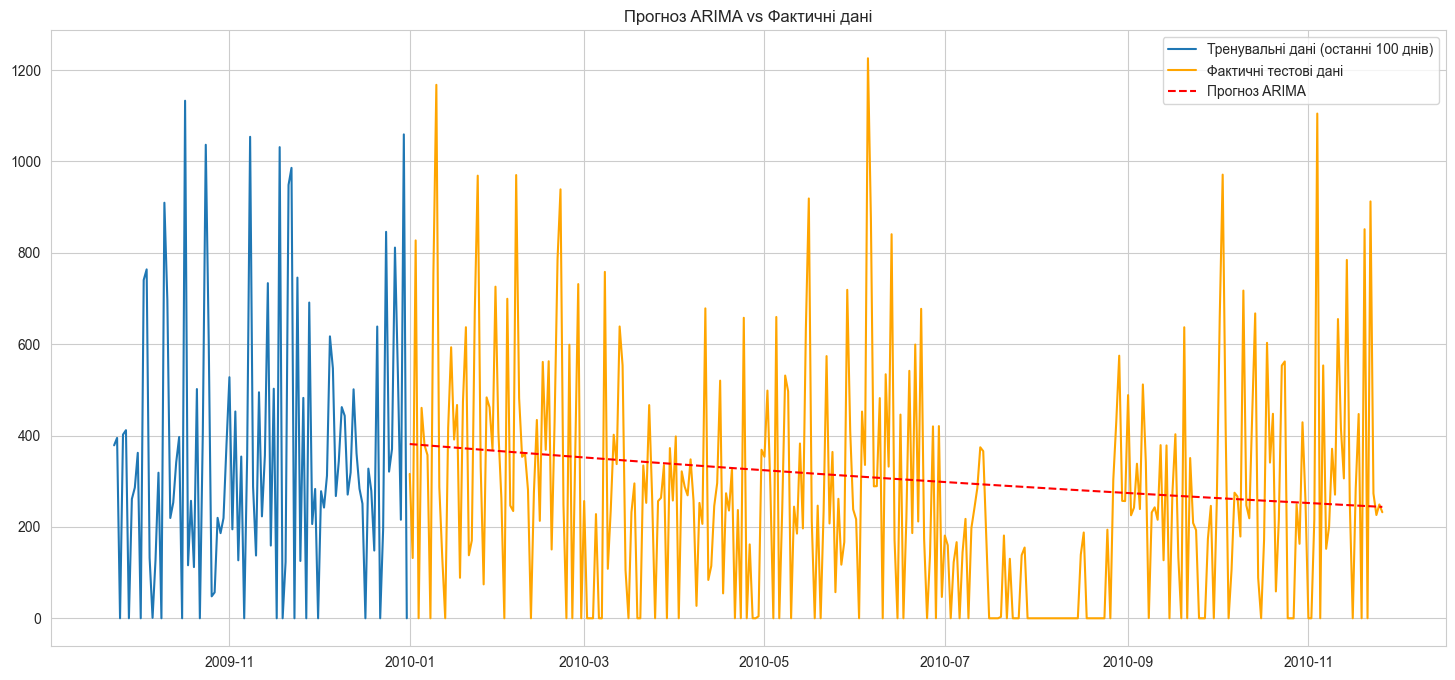

Mean Absolute Error (MAE): 200.35
Root Mean Squared Error (RMSE): 251.42

Модель ARIMA успішно збережена.


In [7]:
# Робимо прогноз
n_periods = len(test_data)
predictions, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True)

# Створюємо DataFrame з прогнозами
predictions_df = pd.Series(predictions, index=test_data.index)

# Візуалізація результатів
plt.plot(train_data.iloc[-100:], label='Тренувальні дані (останні 100 днів)') # Покажемо лише кінець трейн сету для наочності
plt.plot(test_data, label='Фактичні тестові дані', color='orange')
plt.plot(predictions_df, label='Прогноз ARIMA', color='red', linestyle='--')
plt.title('Прогноз ARIMA vs Фактичні дані')
plt.legend()
plt.show()

# Оцінка точності
mae = mean_absolute_error(test_data, predictions_df)
rmse = np.sqrt(mean_squared_error(test_data, predictions_df))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Збереження моделі
joblib.dump(arima_model, '../models/arima_model.pkl')
print("\nМодель ARIMA успішно збережена.")